# Kaggle Leaf Classification Challenge


In [ ]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# I deleted filler text to prevent it from cluttering my workspace (less scrolling)

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [2]:
# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [3]:
# Your code here:
print("Number of training images:", len(train))
print("Number of test images:", len(test))

print("Number of different features (train):", len(train.columns))
print("Number of different test and train features (test):", len(test.columns))
num_species = len(train["species"].unique())
print("Number of different species (train):", num_species)

print("\nWe do not have the species in the test data")

Number of training images: 990
Number of test images: 594
Number of different features (train): 194
Number of different test and train features (test): 193
Number of different species (train): 99

We do not have the species in the test data


With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

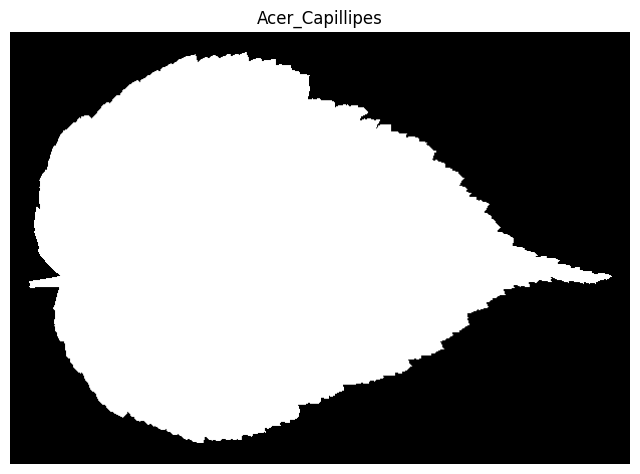

In [4]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_ids = [np.random.choice(train[train.species == s].id.values) for s in species]

# Load images with name {id}.jpg from images folder where id is in species_ids
image_paths = ['images/{}.jpg'.format(i) for i in species_ids]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[0], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

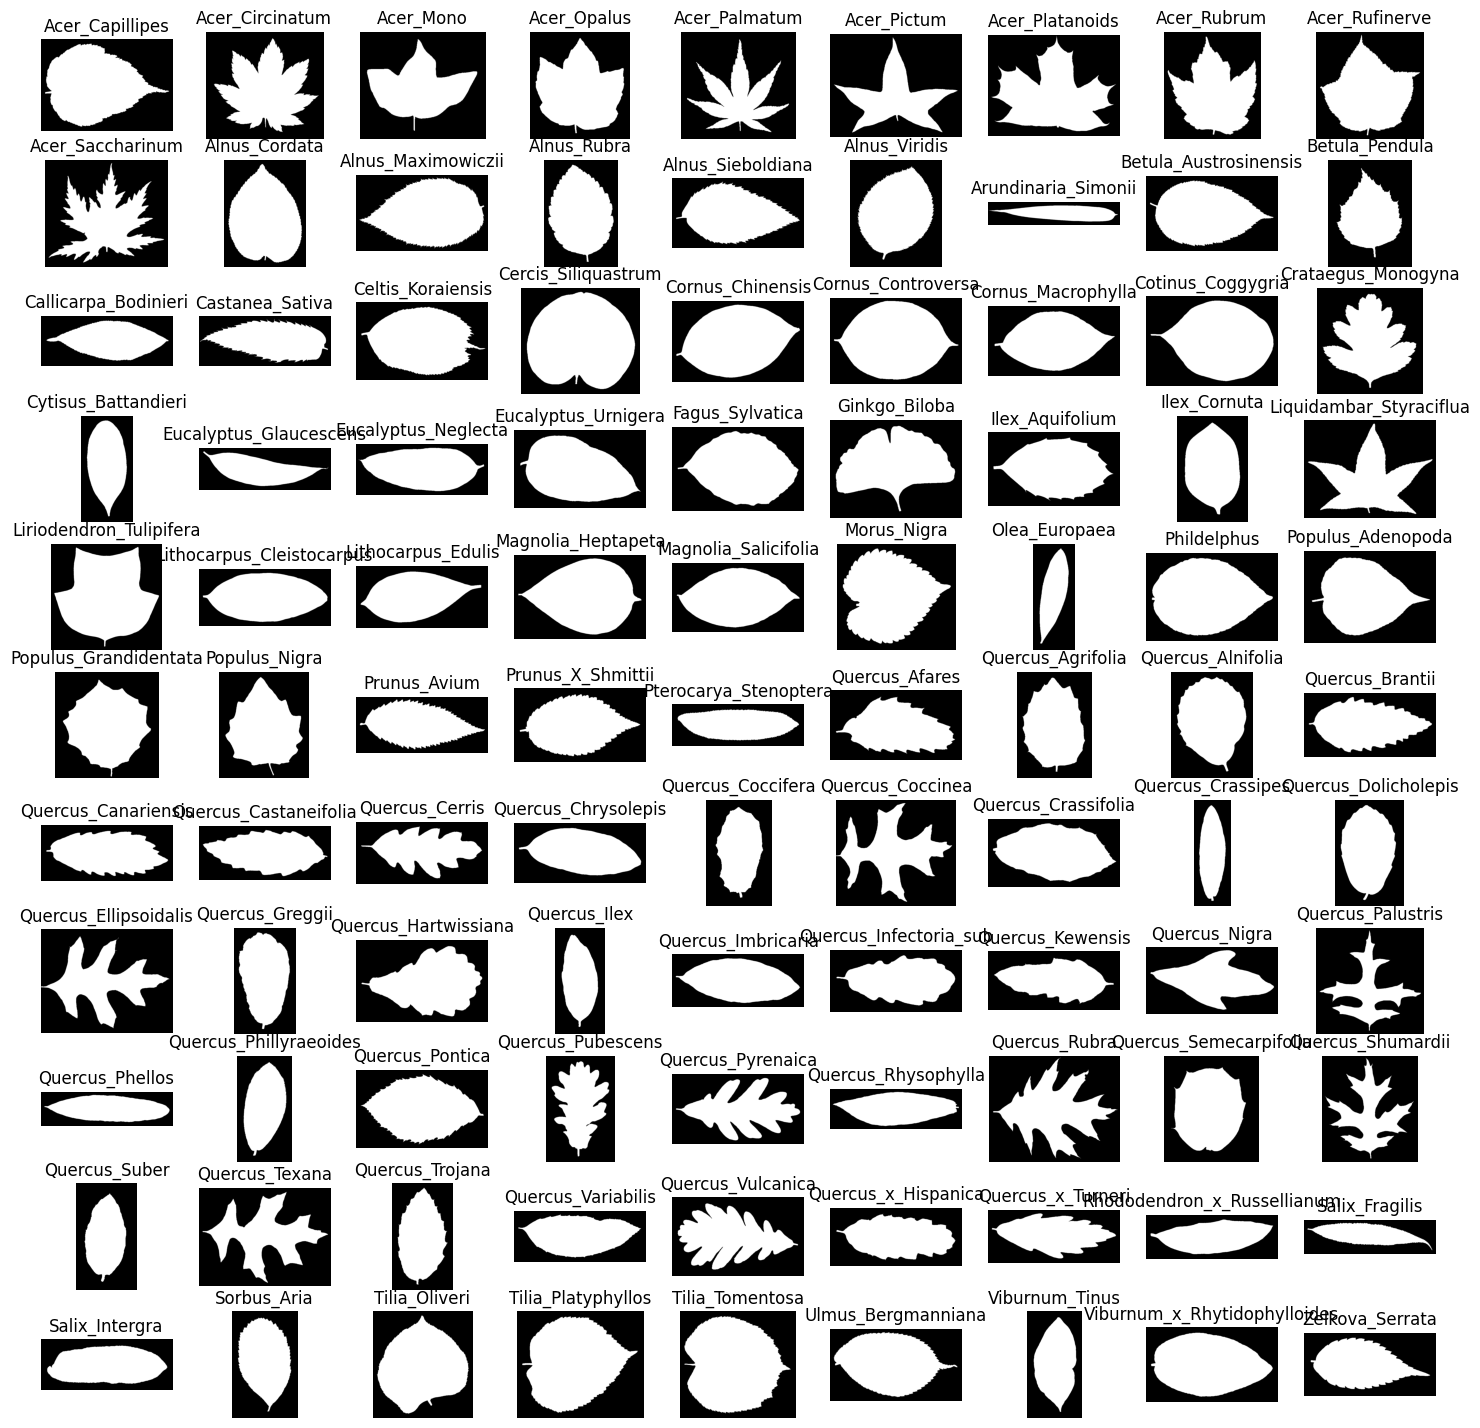

In [5]:
# Now plot 1 image from each category
fig, axs = plt.subplots(11,9, figsize=(18, 18))

for x in range(11):
    for y in range(9):
        image = imread(image_paths[x*9+y], as_gray=True)
        axs[x,y].imshow(image, cmap='gray')
        axs[x,y].set_title("%s" % (species[x*9+y]))
        axs[x,y].axis('off')

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


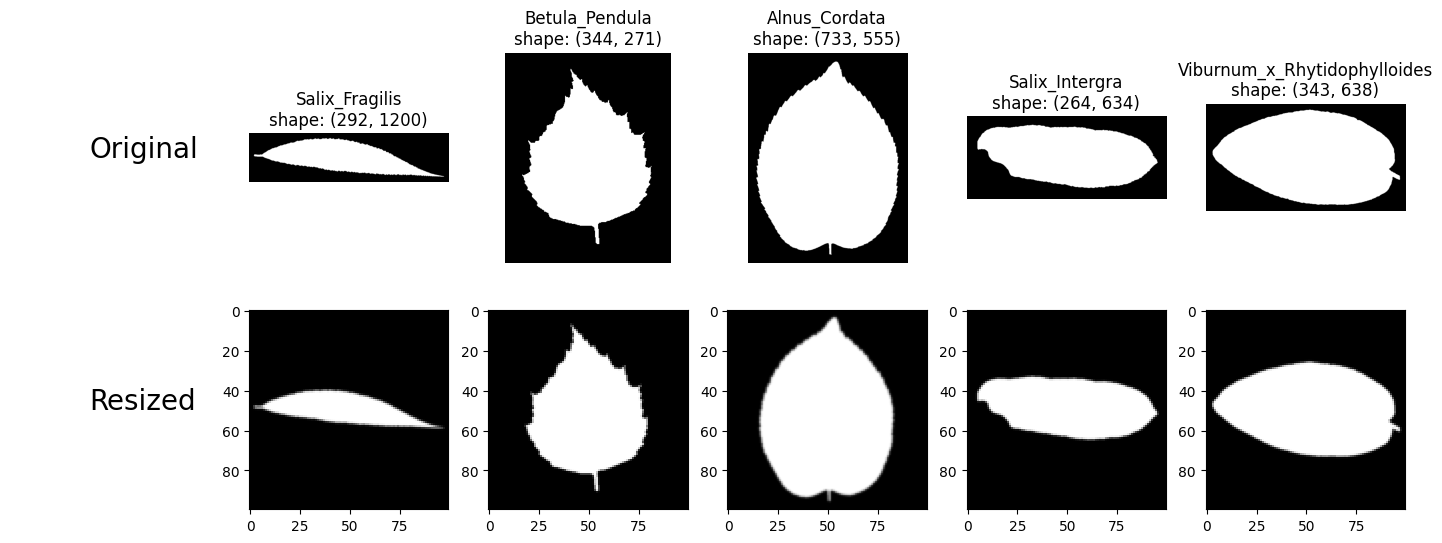

In [9]:
## Image pre-processing
image_size = (100, 100)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

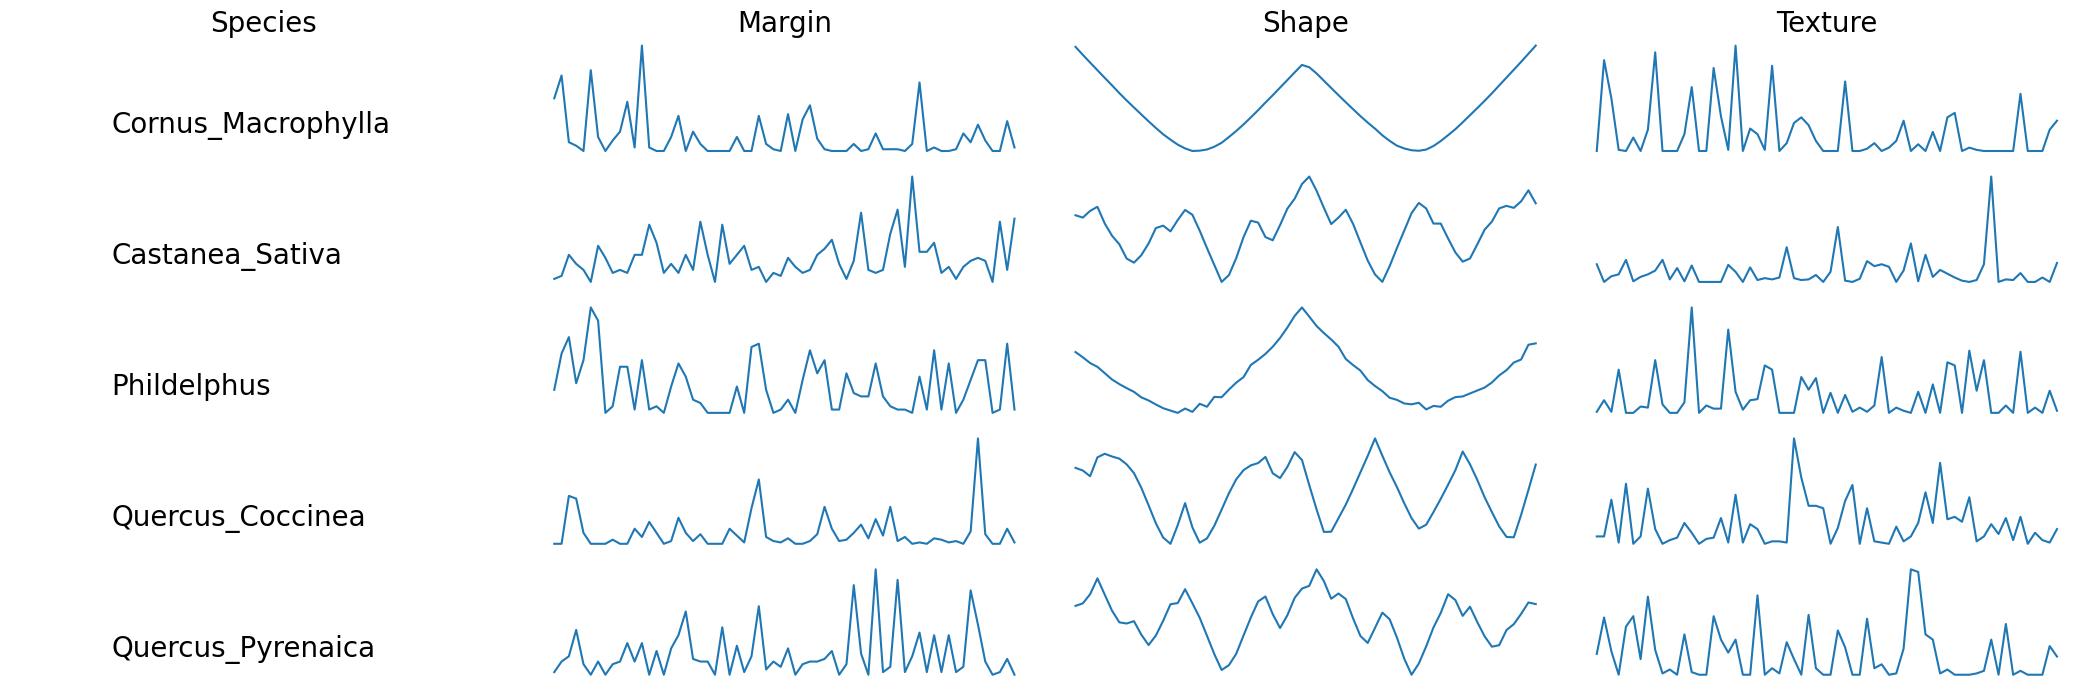

In [7]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**
 Since the shape is "smooth" I could be interesting to use a 1d convolution to perform feature extraction. For the others a general FFNN would probabily do the trick.

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [149]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE =    (100,100,1)
NUM_CLASSES =    num_species

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64

In [48]:
# Paths to data
TRAIN_PATH = "train.csv" 
TEST_PATH = "test.csv" 
IMAGE_DIR = "images"
IMAGE_PATHS = [os.path.join(IMAGE_DIR, filename) for filename in os.listdir(IMAGE_DIR) if filename.endswith('.jpg')]

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 100, 100, 1)0.281170
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 100, 100, 1)	0.281458
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [ ]:
# import pickle

# # Dump the data into a pickle file
# with open(drive_path + '/data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# # Load the data from a pickle file
# with open(drive_path + '/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:** A greater batch size makes more stable gradients (less random). This can both be good and bad since to stable gradients may lock us into a local minima (suboptimal optimization) while a to small batch size may result in unstable gradients (slow learning). If we use the propper batch matrix multiplication techniques the batch size should not have that big of an influence on the trianing speed. One limiting factor of how big of a batch size we can choose depends on our memory.

In [158]:
batch_size = 128
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (128, 100, 100, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ts, (128, 99)

VALID
	images, (99, 100, 100, 1)
	margins, (99, 64)
	shapes, (99, 64)
	textures, (99, 64)
	ts, (99, 99)

TEST
	images, (128, 100, 100, 1)
	margins, (128, 64)
	shapes, (128, 64)
	textures, (128, 64)
	ids, 128


# Build the model

In [50]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, LazyConv2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [159]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [173]:
img_height, img_width, img_channels = 100, 100, 1

MARGIN_SIZE = 64
SHAPE_SIZE = 64
TEXTURE_SIZE = 64

resnet_channels = 64
resnet_blocks = 5

class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()

        conv_1 = LazyConv2d(channels, kernel_size = 3, padding = 1)
        conv_2 = LazyConv2d(channels, kernel_size = 3, padding = 1)

        self.sequence = nn.Sequential(
            conv_1,
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            conv_2,
            nn.BatchNorm2d(channels)
        )

        self.relu_out = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.sequence(x)
        out += x
        out = self.relu_out(out)
        return out
    
class ImageFeatureNet(nn.Module):

    def __init__(self):
        super(ImageFeatureNet, self).__init__()

        conv_start = nn.Conv2d(in_channels = img_channels,
                        out_channels = resnet_channels,
                        kernel_size = 7,
                        stride = 3,
                        padding = 1)
        
        self.sequence_start = nn.Sequential(
            conv_start,
            nn.Dropout2d(p=0.35),
            nn.BatchNorm2d(resnet_channels),
            nn.ReLU(inplace=True)
            )
        
        self.res_net_seq = []

        for i in range(resnet_blocks):
            resnet_block = ResNetBlock(resnet_channels)

            dropout = nn.Dropout(p=0.35)
            batch_norm = nn.BatchNorm2d(resnet_channels)
            max_pool = nn.MaxPool2d(kernel_size=2)

            sequence = nn.Sequential(
                resnet_block,
                dropout,
                batch_norm,
                max_pool
            )
            self.res_net_seq.append(sequence)

        self.end_conv = nn.Conv2d(in_channels = resnet_channels,
                        out_channels = resnet_channels,
                        kernel_size = 5,
                        stride = 2,
                        padding = 1)

    def forward(self, x):

        x = self.sequence_start(x)
        for seq in self.res_net_seq:
            x = seq(x)

        return x

class FeatureNet(nn.Module):

    def __init__(self):
        super(FeatureNet, self).__init__()

        self.rnn_1 = GRU(input_size=64,
                        hidden_size=32,
                        num_layers=3,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0.35)
        self.rnn_2 = GRU(input_size=64,
                        hidden_size=32,
                        num_layers=3,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0.35)
        self.rnn_3 = GRU(input_size=64,
                        hidden_size=32,
                        num_layers=3,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0.35)

    def forward(self, x_shape, x_margin, x_texture):
            
        x_shape, _ = self.rnn_1(x_shape)
        x_margin, _ = self.rnn_2(x_margin)
        x_texture, _ = self.rnn_3(x_texture)

        return torch.concat((x_shape, x_margin, x_texture), dim=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Image feature extractor ##
        self.image_feature_net = ImageFeatureNet()
        
        self.feature_net = FeatureNet()

        self.sequential = nn.Sequential(
            nn.Linear(in_features=256,
                        out_features=128,
                        bias=False),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128,
                        out_features=64,
                        bias=False),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )

        self.l_out = Linear(in_features=64,
                            out_features=NUM_CLASSES,
                            bias=False)

        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        out = {}
        
        x_img = x_img.permute((0, 3, 1, 2)) # Ensure correct dimensions

        ## Image feature extractor ##
        features_img = self.image_feature_net(x_img)
        features_img = features_img.reshape(features_img.size(0), -1)

        ## Feature extractor ##
        features_other = self.feature_net(x_shape, x_margin, x_texture)


        ## Combine all features ##
        features_final = torch.cat((features_img, features_other), dim=1)


        features_final = self.sequential(features_final)
    

        out['out'] = self.l_out(features_final.squeeze()) 
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (image_feature_net): ImageFeatureNet(
    (sequence_start): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(3, 3), padding=(1, 1))
      (1): Dropout2d(p=0.35, inplace=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (end_conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  )
  (feature_net): FeatureNet(
    (rnn_1): GRU(64, 32, num_layers=3, batch_first=True, dropout=0.35, bidirectional=True)
    (rnn_2): GRU(64, 32, num_layers=3, batch_first=True, dropout=0.35, bidirectional=True)
    (rnn_3): GRU(64, 32, num_layers=3, batch_first=True, dropout=0.35, bidirectional=True)
  )
  (sequential): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, o

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [174]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [175]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.5290,  0.5140, -0.2534,  ...,  0.6291,  1.0579,  0.1977],
        [ 0.7352,  0.3887, -0.7497,  ...,  1.2969,  0.4294, -1.1227],
        [ 0.1433,  0.3596, -0.6827,  ...,  0.5820,  0.8141, -0.1743],
        ...,
        [ 0.4808, -0.2506,  0.6802,  ...,  0.3237, -0.0313, -0.5681],
        [ 0.5107,  0.2060, -0.9801,  ...,  0.7450,  0.8897, -0.8068],
        [ 0.5118, -0.0468,  0.1357,  ...,  0.1491,  0.6545,  0.0923]],
       grad_fn=<MmBackward0>)

# Train

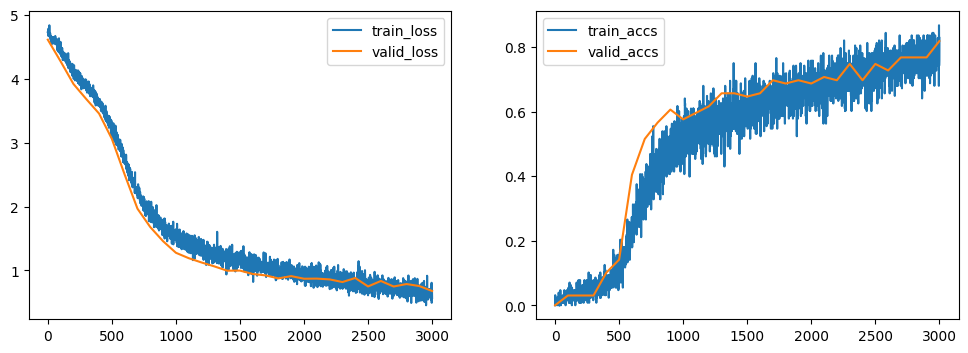

In [176]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 3000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [177]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()

#softmax
softmax = nn.Softmax(dim=1)

# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [178]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,-16.431917,-3.692765,-12.165981,6.507382,-3.007363,-11.556082,-1.752957,-6.718908,-6.200525,...,-19.543367,-7.171795,-10.311195,-2.488303,-8.213398,-6.183621,-18.237473,0.584351,-17.482521,-15.552443
1,7,-11.268108,-15.612682,-8.822647,-1.721940,-14.897749,-10.302228,-1.987601,-13.287771,-17.082939,...,-11.258132,2.264567,-16.018728,-3.802345,-7.986552,-7.407174,-11.113317,-11.170952,-6.596694,-0.572287
2,9,-2.199881,12.038462,-13.050154,-9.075606,9.412482,-3.342640,-11.766441,-0.244106,6.088742,...,-17.254314,-29.592939,-1.551481,-11.388165,-16.185104,-7.554371,-15.344584,-6.911182,-27.993504,-16.833336
3,12,-3.981310,-9.568195,-18.928072,-18.664610,-18.003592,-14.907425,-18.004055,-13.721401,-16.876547,...,0.490110,-11.521482,-14.168923,-21.018326,-11.361701,-10.431848,-0.560295,-12.214479,-10.262217,5.586907
4,13,-3.980488,1.770873,-13.473575,-2.479691,-0.763502,-7.449083,-16.615286,8.337276,3.229376,...,-9.269792,-20.910282,9.222461,-0.112612,3.815708,4.566759,-0.345147,1.962655,-14.331156,-16.125172


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 